## Imports & Constants

In [1]:
import os
import thinkdsp as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcols
import cv2
import seaborn as sns

from scipy import signal
from random import choice
from typing import Optional, List, Tuple
from queue import PriorityQueue

In [83]:
AUDIO_ROOTS = ['train_audio', 'test_audio']
CLASS_NAMES = os.listdir(AUDIO_ROOTS[0])
DEFAULT_SEG_L = 1024
FRAMERATE = 16000
EPSILON = 10 ** -6
LIMIT_PCR = 0.15

np.set_printoptions(precision=3)

## Analyze audios

In [122]:
def get_random_wave(class_name: Optional[str] = None) -> Tuple[str, tp.Wave]:
    if not class_name or CLASS_NAMES.index(class_name) == -1:
        class_name = choice(CLASS_NAMES)
    audio_root = choice(AUDIO_ROOTS)
    audios = os.listdir(f'{audio_root}/{class_name}')
    return class_name, tp.read_wave(f'{audio_root}/{class_name}/{choice(audios)}')

In [119]:
get_random_wave()[1].make_audio()

In [120]:
get_random_wave('yes')[1].make_audio()

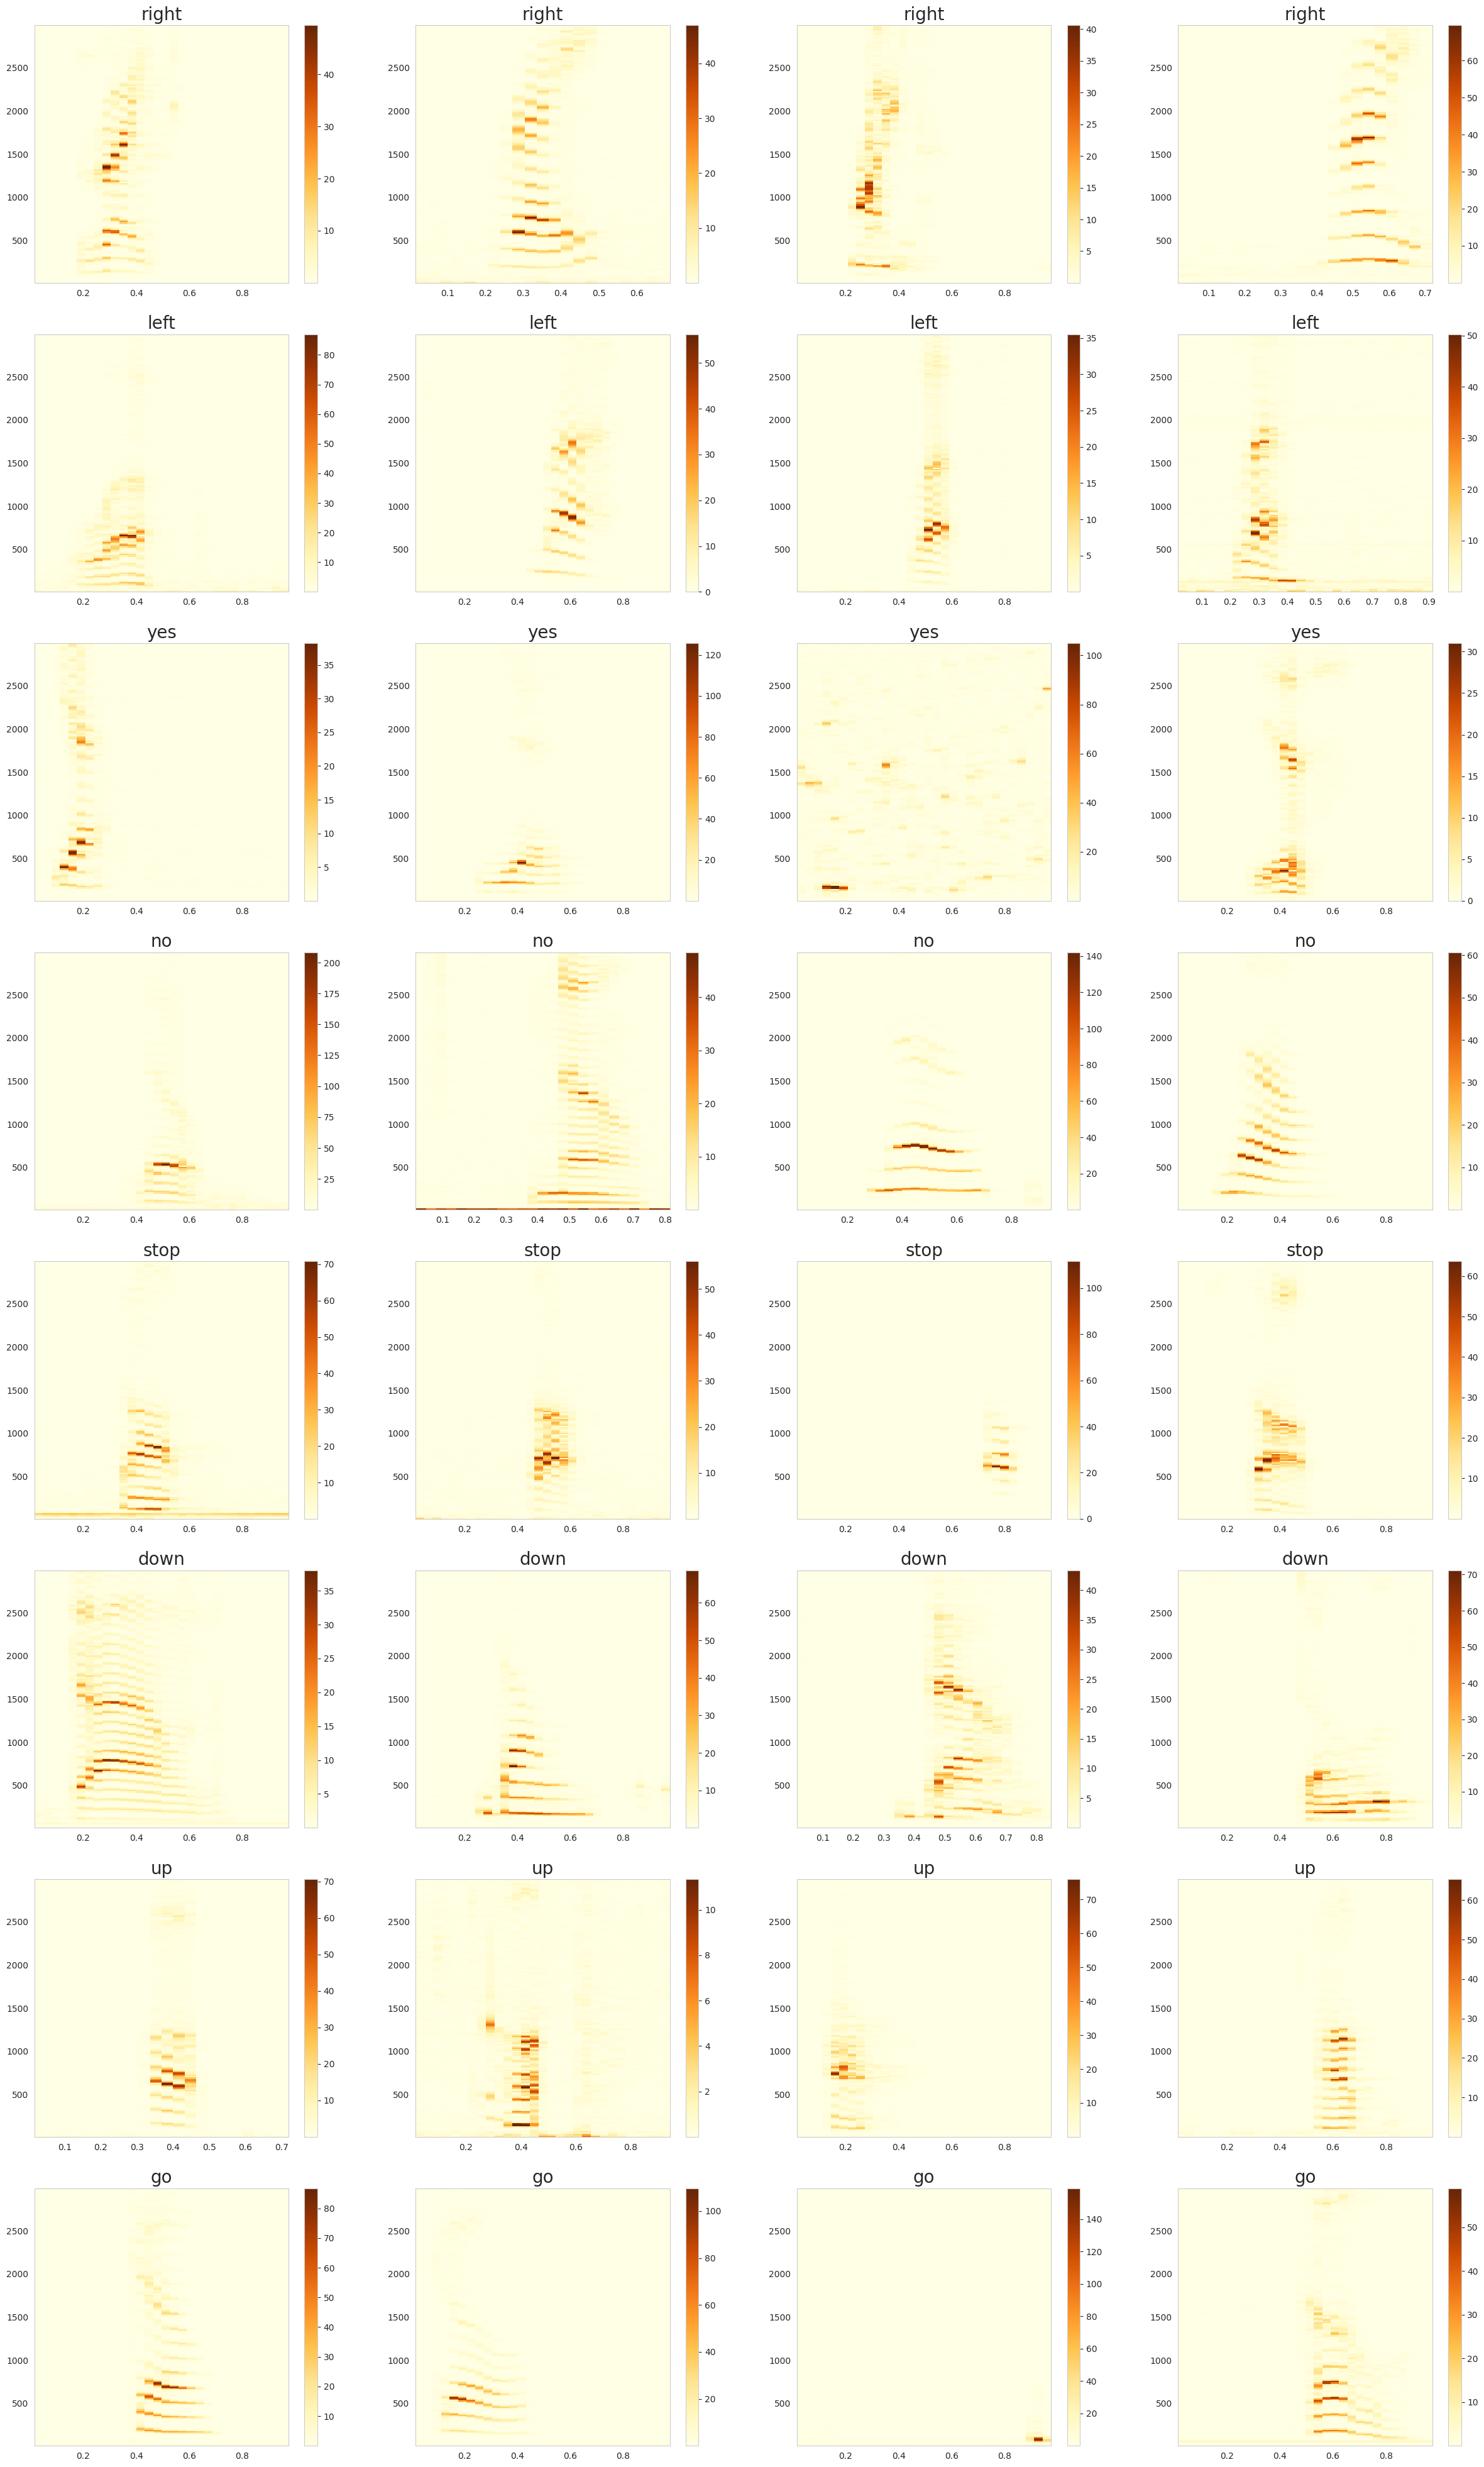

In [8]:
SAMPLES = 4


def spectrogram_to_map(spectrogram: tp.Spectrogram,
                       high: Optional[float] = None,
                       low: Optional[float] = None) -> Tuple[np.ndarray, ...]:
    fs = spectrogram.frequencies()
    h_idx = None if high is None else tp.find_index(high, fs)
    l_idx = None if low is None else tp.find_index(low, fs)
    fs = fs[l_idx:h_idx]
    ts = spectrogram.times()

    # make the array
    size = len(fs), len(ts)
    array = np.zeros(size, dtype=complex)

    # copy amplitude from each spectrum into a column of the array
    for j, t in enumerate(ts):
        spectrum = spectrogram.spec_map[t]
        array[:, j] = spectrum.hs[l_idx:h_idx]

    return ts, fs, array


def plot_spec(spectrogram: tp.Spectrogram,
              ax: Optional[plt.Axes] = None,
              high: Optional[float] = None,
              low: Optional[float] = None) -> mcols.QuadMesh:
    if not ax:
        ax = plt.gca()

    ts, fs, array = spectrogram_to_map(spectrogram, high, low)
    return ax.pcolormesh(ts, fs, np.abs(array), cmap='YlOrBr')


# Usual human speech frequencies are in the range 25 - 500 Hz,
# so we can throw out frequencies higher than 3000 Hz
def plot_specs(high: int = 3000, low: int = 20):
    fig: plt.Figure
    axes: List[List[plt.Axes]]
    fig, axes = plt.subplots(len(CLASS_NAMES), SAMPLES, figsize=(30, 50))

    for r, class_name in enumerate(CLASS_NAMES):
        for c in range(SAMPLES):
            wave = get_random_wave(class_name)[1]
            spectrogram = wave.make_spectrogram(seg_length=DEFAULT_SEG_L)
            im = plot_spec(spectrogram, axes[r][c], high, low)
            axes[r][c].set_title(class_name, fontsize=20)
            fig.colorbar(im, ax=axes[r][c])

    plt.show()


plot_specs()

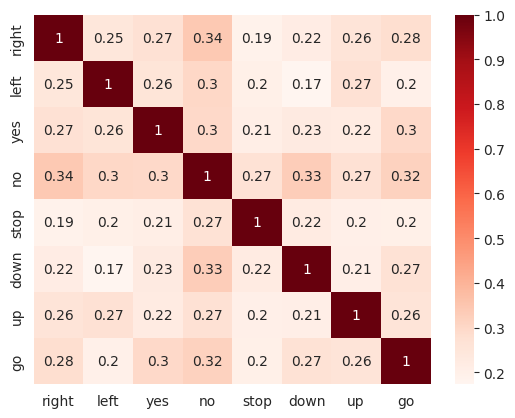

In [80]:
# Find center of spectrogram
def find_center(vals: np.ndarray) -> int:
    cuml = 0
    coef = 0
    for i in range(vals.shape[1]):
        l_sum = np.abs(np.sum(vals[:, i]))
        l_sum = 1 if l_sum < 1 else l_sum
        cuml += i * l_sum
        coef += l_sum
    return int(cuml / coef)


def corr2_coeff(a: np.ndarray, b: np.ndarray) -> float:
    a_m_a = a - a.mean(1)[:, None]
    b_m_b = b - b.mean(1)[:, None]

    # Sum of squares across rows
    ss_a = (a_m_a ** 2).sum(1)
    ss_b = (b_m_b ** 2).sum(1)

    # Finally get corr coeff
    mat_dot = np.dot(a_m_a, b_m_b.T)
    mean_dot = np.sqrt(np.dot(ss_a[:, None], ss_b[None]))
    coefs = np.zeros(mat_dot.shape, dtype=float)

    for i in range(coefs.shape[0]):
        for j in range(coefs.shape[1]):
            if mat_dot[i][j] < EPSILON and mean_dot[i][j] < EPSILON:
                coefs[i][j] = 1
            else:
                coefs[i][j] = mat_dot[i][j] / mean_dot[i][j]

    return np.trace(coefs) / coefs.shape[0]


# Find correlation matrix by many trial
def find_corr(rounds: int = 20, high: int = 3000, low: int = 20):
    corr_mat = np.zeros((len(CLASS_NAMES), len(CLASS_NAMES)))
    for _ in range(rounds):
        # Take samples
        samples = [
            spectrogram_to_map(
                get_random_wave(class_name)[1].make_spectrogram(seg_length=DEFAULT_SEG_L),
                high=high,
                low=low
            )[-1]
            for class_name in CLASS_NAMES
        ]
        min_r, min_c = samples[0].shape

        # center all spectrograms
        for i, s_i in enumerate(samples):
            real_c = find_center(s_i)
            geom_c = s_i.shape[1] // 2
            samples[i] = np.roll(s_i, geom_c - real_c)
            min_r = min(min_r, s_i.shape[0])
            min_c = min(min_c, s_i.shape[1])

        # Resize
        for i, s_i in enumerate(samples):
            # noinspection PyUnresolvedReferences
            samples[i] = cv2.resize(np.abs(s_i), dsize=(min_c, min_r))

        for i, s_i in enumerate(samples):
            for j, s_j in enumerate(samples):
                corr_mat[i][j] += ((corr2_coeff(s_i, s_j) + corr2_coeff(s_i.T, s_j.T)) / 2)

    return corr_mat / rounds


# Plot correlation
def plot_corr(rounds: int = 10, high: int = 3000, low: int = 20):
    corr_mat = find_corr(rounds, high, low)
    sns.heatmap(
        corr_mat, annot=True, cmap='Reds',
        xticklabels=[class_name for class_name in CLASS_NAMES],
        yticklabels=[class_name for class_name in CLASS_NAMES],
    )


plot_corr()

## Synthesize audio

In [123]:
PICKS = 750


def most_significant(picks: List[Tuple[complex, int, int]]) -> int:
    cuml = 0
    coef_sum = 0

    for pick in picks:
        val = np.abs(pick[0]) if np.abs(pick[0]) > 1 else 1
        t = pick[2] + 1
        cuml += val * t
        coef_sum += val

    return int(cuml / coef_sum)


# Find k picks on spectrogram
def get_picks(vals: np.ndarray, k: int) -> List[Tuple[complex, int, int]]:
    picks = PriorityQueue(maxsize=k)
    for i in range(vals.shape[0]):
        for j in range(vals.shape[1]):
            cur = np.abs(vals[i][j])

            if 0 < j < vals.shape[1] - 1:
                left = np.abs(vals[i][j - 1])
                right = np.abs(vals[i][j + 1])
                if not (left < cur > right):
                    continue  # Consider only picks

            if picks.full():
                if picks.queue[0][0] > cur:
                    continue
                picks.get()

            picks.put((cur, i, j))

    return sorted(
        [(vals[i][j], i, j) for _, i, j in picks.queue],
        key=lambda x: x[-1]
    )


# Group picks by time index
def group_picks(picks: List[Tuple[complex, int, int]]) -> List[List[Tuple[complex, int, int]]]:
    groups = []

    for pick in picks:
        if not groups:
            groups.append([pick])
            continue

        if groups[-1][-1][-1] == pick[-1]:
            groups[-1].append(pick)
        else:
            groups.append([pick])

    return groups


def spectrum_from_group(group: List[Tuple[complex, int, int]], fs: np.ndarray, shift: int) -> tp.Spectrum:
    hs = np.zeros(len(fs), dtype=complex)
    for pick in group:
        hs[shift + pick[1]] = pick[0]
    return tp.Spectrum(hs, fs, FRAMERATE)


# Make a synthesized copy of random sample
def random_synthesize(class_name: Optional[str] = None,
                      high: Optional[float] = None,
                      low: Optional[float] = None) -> Tuple[int, tp.Wave]:
    if not class_name or CLASS_NAMES.index(class_name) == -1:
        class_name = choice(CLASS_NAMES)
    wave = get_random_wave(class_name)[1]
    spectrogram = wave.make_spectrogram(seg_length=DEFAULT_SEG_L)
    ts, fs, vals = spectrogram_to_map(spectrogram, high, low)
    picks = get_picks(vals, PICKS)
    groups = group_picks(picks)

    ys = np.zeros(len(wave.ys))
    shift = tp.find_index(low, fs)
    for group in groups:
        group_idx = group[0][2]
        spectrum = spectrum_from_group(group, spectrogram.frequencies(), shift)
        sub_wave = spectrum.make_wave()
        start = group_idx * DEFAULT_SEG_L // 2
        ys[start:start + DEFAULT_SEG_L] += sub_wave.ys

    return most_significant(picks), tp.Wave(ys, framerate=FRAMERATE)


# Add noice to the wave
def add_noice(wave: tp.Wave, amp: float) -> tp.Wave:
    noice = tp.BrownianNoise(amp).make_wave(wave.duration, framerate=wave.framerate)
    new_wave = wave + noice
    return new_wave

In [124]:
PAIRS = {
    'right': 'stop',
    'left': 'down',
    'yes': 'stop',
    'no': 'up',
    'stop': 'left',
    'down': 'left',
    'up': 'stop',
    'go': 'left'
}


# Insert malware
def insert_malware(wave: tp.Wave, class_name: str,
                   high: Optional[float] = None,
                   low: Optional[float] = None,
                   noice_amp: float = 0.1) -> tp.Wave:
    # Generate noisy synthesized wave
    m_sign, malware = random_synthesize(PAIRS[class_name], high=high, low=low)
    malware = add_noice(malware, noice_amp)
    malware.normalize()
    m_ys = np.array(malware.ys)
    m_idx = m_sign * DEFAULT_SEG_L // 2

    # Find most significant part of given wave
    # Will insert zeros at this  place
    spectrogram = wave.make_spectrogram(seg_length=DEFAULT_SEG_L)
    ts, fs, vals = spectrogram_to_map(spectrogram, high, low)
    picks = get_picks(vals, PICKS)
    ys = np.array(wave.ys)
    w_sign = most_significant(picks)
    w_idx = w_sign * DEFAULT_SEG_L // 2
    window = int(len(ys) * LIMIT_PCR)

    # Insert malware
    # It's guaranteed that
    # inserted part <= window <= LIMIT_PRC * (wave length)
    l_sft = min(window // 2, w_idx, m_idx)
    r_sft = min(window // 2, len(ys) - w_idx, len(m_ys) - m_idx)
    ys[w_idx - l_sft: w_idx + r_sft] = m_ys[m_idx - l_sft: m_idx + r_sft]

    return tp.Wave(ys, framerate=FRAMERATE)

In [130]:
AUDIO_ROOTS = ['test_audio']

# generate corrupted data
def gen_corrupted(source_dir: str, dest_dir: str,
                  high: Optional[float] = None,
                  low: Optional[float] = None,
                  noice_amp: float = 0.1):
    # Create necessary folders
    if not os.path.isdir(dest_dir):
        os.makedirs(dest_dir, exist_ok=True)
    for class_name in CLASS_NAMES:
        if not os.path.isdir(f'{dest_dir}/{class_name}'):
            os.mkdir(f'{dest_dir}/{class_name}')

    for class_name in CLASS_NAMES:
        audios_names = os.listdir(f'{source_dir}/{class_name}')
        for audio_name in audios_names:
            audio_path = f'{source_dir}/{class_name}/{audio_name}'
            print(f'Process: {audio_path}')
            wave = tp.read_wave(audio_path)
            wave.normalize()
            corrupted = insert_malware(
                wave, class_name, high, low, noice_amp
            )
            corrupted.write(f'{dest_dir}/{class_name}/{audio_name}')
    print('Finished!')

gen_corrupted('test_audio', 'corrupted', 3000, 20)

Process: test_audio/right/f19c1390_nohash_0.wav
Writing corrupted/right/f19c1390_nohash_0.wav
Process: test_audio/right/f2dd248e_nohash_1.wav
Writing corrupted/right/f2dd248e_nohash_1.wav
Process: test_audio/right/ec21c46b_nohash_0.wav
Writing corrupted/right/ec21c46b_nohash_0.wav
Process: test_audio/right/eb0676ec_nohash_3.wav
Writing corrupted/right/eb0676ec_nohash_3.wav
Process: test_audio/right/fac74f6a_nohash_1.wav
Writing corrupted/right/fac74f6a_nohash_1.wav
Process: test_audio/right/d71ad617_nohash_1.wav
Writing corrupted/right/d71ad617_nohash_1.wav
Process: test_audio/right/f8f60f59_nohash_4.wav
Writing corrupted/right/f8f60f59_nohash_4.wav
Process: test_audio/right/d0858dce_nohash_0.wav
Writing corrupted/right/d0858dce_nohash_0.wav
Process: test_audio/right/f292725f_nohash_0.wav
Writing corrupted/right/f292725f_nohash_0.wav
Process: test_audio/right/dc75148d_nohash_0.wav
Writing corrupted/right/dc75148d_nohash_0.wav
Process: test_audio/right/f2dd248e_nohash_2.wav
Writing corr